# Text Preprocessing



In the previous section we discussed some properties that make language
unique. The key is that the number of tokens (aka words) is large and very
unevenly distributed. Hence, a naive multiclass classification approach to
predict the next symbol doesn't always work very well. Moreover, we need to turn
text into a format that we can optimize over, i.e. we need to map it to
vectors. At its extreme we have two alternatives. One is to treat each word as a
unique entity, e.g. `Salton.Wong.Yang.1975`.  The problem with this
strategy is that we might well have to deal with 100,000 to 1,000,000 vectors
for very large and diverse corpora.

At the other extreme lies the strategy to predict one character at a time, as
suggested e.g. by [Ling et al., 2015](https://arxiv.org/pdf/1508.02096.pdf). A
good balance in between both strategies is
[byte-pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding), as
described by
[Sennrich, Haddow and Birch, 2015](https://arxiv.org/abs/1508.07909) for the
purpose of neural machine translation. It decomposes text into syllable-like
fragments that occur frequently. This allows for models that are able to
generate words like `heteroscedastic` or `pentagram` based on previously viewed
words, e.g. `heterogeneous`, `homoscedastic`, `diagram`, and `pentagon`. Going
into details of these models is beyond the scope of the current chapter. We will
address this later when discussing
natural language processing (`chapter_nlp`) in much
more detail. Suffice it to say that it can contribute significantly to the
accuracy of natural language processing models.

For the sake of simplicity we will limit ourselves to pure character sequences. We use H.G. Wells' *The Timemachine* as before. We begin by filtering the text and convert it into a a sequence of character IDs.

## Data Loading

We begin, as before, by loading the data and by mapping it into a sequence of whitespaces, punctuation signs and regular characters. Preprocessing is minimal and we limit ourselves to removing multiple whitespaces.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import random
import collections

with open('../data/timemachine.txt', 'r') as f:
    raw_text = f.read()
print(raw_text[0:110])

The Time Machine, by H. G. Wells [1898]




I


The Time Traveller (for so it will be convenient to speak of h


## Tokenization

Next we need to split the dataset, a string, into tokens. A token is a data point the model will train and predict. We common use a word or a character as a token.

In [2]:
lines = raw_text.split('\n')
text = ' '.join(' '.join(lines).lower().split())
print('# of chars:', len(text))
print(text[0:70])

# of chars: 178605
the time machine, by h. g. wells [1898] i the time traveller (for so i


## Vocabulary

Then we need to map tokens into numerical indices. We often call it a vocabulary. Its input is a list of tokens,  called a corpus. Then it counts the frequency of each token in this corpus, and then assigns an numerical index to each token according to its frequency. Rarely appeared tokens are often removed to reduce the complexity. A token doesn't exist in corpus or has been removed is mapped into a special unknown (“&lt;unk&gt;”) token. We optionally add another three special tokens: “&lt;pad&gt;” a token for padding, “&lt;bos&gt;” to present the beginning for a sentence, and “&lt;eos&gt;” for the ending of a sentence.

In [3]:
class Vocab(object):  # This class is saved in d2l.
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        # sort by frequency and token
        counter = collections.Counter(tokens)
        token_freqs = sorted(counter.items(), key=lambda x: x[0])
        token_freqs.sort(key=lambda x: x[1], reverse=True)
        if use_special_tokens:
            # padding, begin of sentence, end of sentence, unknown
            self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
            tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        else:
            self.unk = 0
            tokens = ['<unk>']
        tokens +=  [token for token, freq in token_freqs if freq >= min_freq]
        self.idx_to_token = []
        self.token_to_idx = dict()
        for token in tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        else:
            return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        else:
            return [self.idx_to_token[index] for index in indices]

We construct a vocabulary with the time machine dataset as the corpus, and then print the map between tokens to indices.

In [4]:
vocab = Vocab(text)
print(vocab.token_to_idx)

{'<unk>': 0, ' ': 1, 'e': 2, 't': 3, 'a': 4, 'i': 5, 'n': 6, 'o': 7, 's': 8, 'h': 9, 'r': 10, 'd': 11, 'l': 12, 'm': 13, 'u': 14, 'c': 15, 'f': 16, 'w': 17, 'g': 18, 'y': 19, 'p': 20, ',': 21, 'b': 22, '.': 23, 'v': 24, 'k': 25, "'": 26, '-': 27, 'x': 28, 'z': 29, ';': 30, 'j': 31, '?': 32, 'q': 33, '!': 34, '"': 35, '_': 36, ':': 37, '(': 38, ')': 39, '8': 40, '[': 41, ']': 42, '1': 43, '9': 44}


After that, each character in the training data set is converted into an index ID. To illustrate things we print the first 20 characters and their corresponding indices.

In [5]:
corpus_indices = [vocab[char] for char in text]
sample = corpus_indices[:15]
print('chars:', [vocab.idx_to_token[idx] for idx in sample])
print('indices:', sample)

chars: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n']
indices: [3, 9, 2, 1, 3, 5, 13, 2, 1, 13, 4, 15, 9, 5, 6]


We packaged the above code in the `(corpus_indices, vocab) = load_data_time_machine()` function of the `d2l` package to make it easier to call it in later chapters.

## Training Data Preparation

During training, we need to read mini-batches of examples and labels at
random. Since sequence data is by its very nature sequential, we need to address
the issue of processing it. We did so in a rather ad-hoc manner when we
introduced in `chapter_sequence`. Let's formalize this a bit. Consider the beginning of the book we just processed. If we want to split it up into sequences of 5 symbols each, we have quite some freedom since we could pick an arbitrary offset.




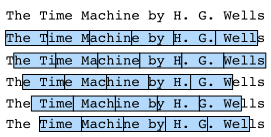

In [6]:
from IPython.display import SVG
SVG(filename= '../img/timemachine-5gram.svg')

Fig: Different offsets lead to different subsequences when splitting up text.

In fact, any one of these offsets is fine. Hence, which one should we pick? In fact, all of them are equally good. But if we pick all offsets we end up with rather redundant data due to overlap, particularly if the sequences are long. Picking just a random set of initial positions is no good either since it does not guarantee uniform coverage of the array. For instance, if we pick $n$ elements at random out of a set of $n$ with random replacement, the probability for a particular element not being picked is $(1-1/n)^n \to e^{-1}$. This means that we cannot expect uniform coverage this way. Even randomly permuting a set of all offsets does not offer good guarantees. Instead we can use a simple trick to get both *coverage* and *randomness*: use a random offset, after which one uses the terms sequentially. We describe how to accomplish this for both random sampling and sequential partitioning strategies below.

### Random sampling

The following code randomly generates a minibatch from the data each time. Here, the batch size `batch_size` indicates to the number of examples in each mini-batch and `num_steps` is the length of the sequence (or time steps if we have a time series) included in each example.
In random sampling, each example is a sequence arbitrarily captured on the original sequence. The positions of two adjacent random mini-batches on the original sequence are not necessarily adjacent. The target is to predict the next character based on what we've seen so far, hence the labels are the original sequence, shifted by one character. Note that this is not recommended for latent variable models, since we do not have access to the hidden state *prior* to seeing the sequence. We packaged the above code in the `load_data_time_machine` function of the `d2l` package to make it easier to call it in later chapters. It returns four variables: `corpus_indices`, `char_to_idx`, `idx_to_char`, and `vocab_size`.

In [7]:
# This function is saved in the d2l package for future use
def data_iter_random(corpus_indices, batch_size, num_steps, ctx=None):
    # Offset for the iterator over the data for uniform starts
    offset = int(random.uniform(0,num_steps))
    corpus_indices = corpus_indices[offset:]
    # Subtract 1 extra since we need to account for the sequence length
    num_examples = ((len(corpus_indices) - 1) // num_steps) - 1
    # Discard half empty batches
    num_batches = num_examples // batch_size
    example_indices = list(range(0, num_examples * num_steps, num_steps))
    random.shuffle(example_indices)

    # This returns a sequence of the length num_steps starting from pos
    def _data(pos):
        return corpus_indices[pos: pos + num_steps]

    for i in range(0, batch_size * num_batches, batch_size):
        # Batch_size indicates the random examples read each time
        batch_indices = example_indices[i:(i+batch_size)]
        X = [_data(j) for j in batch_indices]
        Y = [_data(j + 1) for j in batch_indices]
        yield torch.Tensor(X,  device=ctx), torch.Tensor(Y,  device=ctx)

Let us generate an artificial sequence from 0 to 30. We assume that
the batch size and numbers of time steps are 2 and 5
respectively. This means that depending on the offset we can generate between 4 and 5 $(x,y)$ pairs. With a minibatch size of 2 we only get 2 minibatches.

In [8]:
my_seq = list(range(30))
for X, Y in data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[13., 14., 15., 16., 17.],
        [ 8.,  9., 10., 11., 12.]]) 
Y: tensor([[14., 15., 16., 17., 18.],
        [ 9., 10., 11., 12., 13.]])
X:  tensor([[ 3.,  4.,  5.,  6.,  7.],
        [18., 19., 20., 21., 22.]]) 
Y: tensor([[ 4.,  5.,  6.,  7.,  8.],
        [19., 20., 21., 22., 23.]])


### Sequential partitioning

In addition to random sampling of the original sequence, we can also make the positions of two adjacent random mini-batches adjacent in the original sequence. Now, we can use a hidden state of the last time step of a mini-batch to initialize the hidden state of the next mini-batch, so that the output of the next mini-batch is also dependent on the input of the mini-batch, with this pattern continuing in subsequent mini-batches. This has two effects on the implementation of a recurrent neural network. On the one hand,
when training the model, we only need to initialize the hidden state at the beginning of each epoch.
On the other hand, when multiple adjacent mini-batches are concatenated by passing hidden states, the gradient calculation of the model parameters will depend on all the mini-batch sequences that are concatenated. In the same epoch as the number of iterations increases, the costs of gradient calculation rise.
So that the model parameter gradient calculations only depend on the mini-batch sequence read by one iteration, we can separate the hidden state from the computational graph before reading the mini-batch (this can be done by detaching the graph). We will gain a deeper understand this approach in the following sections.

In [9]:
# This function is saved in the d2l package for future use
def data_iter_consecutive(corpus_indices, batch_size, num_steps, ctx=None):
    # Offset for the iterator over the data for uniform starts
    offset = int(random.uniform(0,num_steps))
    # Slice out data - ignore num_steps and just wrap around
    num_indices = ((len(corpus_indices) - offset) // batch_size) * batch_size
    indices = torch.Tensor(corpus_indices[offset:(offset + num_indices)], device=ctx)
    indices = indices.reshape((batch_size,-1))
    # Need to leave one last token since targets are shifted by 1
    num_epochs = ((num_indices // batch_size) - 1) // num_steps

    for i in range(0, num_epochs * num_steps, num_steps):
        X = indices[:,i:(i+num_steps)]
        Y = indices[:,(i+1):(i+1+num_steps)]
        yield X, Y

Using the same settings, print input `X` and label `Y` for each mini-batch of examples read by random sampling. The positions of two adjacent random mini-batches on the original sequence are adjacent.

In [10]:
for X, Y in data_iter_consecutive(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2.,  3.,  4.,  5.,  6.,  7.],
        [16., 17., 18., 19., 20., 21.]]) 
Y: tensor([[ 3.,  4.,  5.,  6.,  7.,  8.],
        [17., 18., 19., 20., 21., 22.]])
X:  tensor([[ 8.,  9., 10., 11., 12., 13.],
        [22., 23., 24., 25., 26., 27.]]) 
Y: tensor([[ 9., 10., 11., 12., 13., 14.],
        [23., 24., 25., 26., 27., 28.]])


Sequential partitioning decomposes the sequence into `batch_size` many strips of data which are traversed as we iterate over minibatches. Note that the $i$-th element in a minibatch matches with the $i$-th element of the next minibatch rather than within a minibatch.

## Summary

* Documents are preprocessed by tokenizing the words and mapping them into IDs. There are multiple methods:
    * Character encoding which uses individual characters (good e.g. for Chinese)
    * Word encoding (good e.g. for English)
    * Byte-pair encoding (good for languages that have lots of morphology, e.g. German)
* The main choices for sequence partitioning are whether we pick consecutive or random sequences. In particular for recurrent networks the former is critical.
* Given the overall document length, it is usually acceptable to be slightly wasteful with the documents and discard half-empty minibatches.

## Exercises

1. Which other other mini-batch data sampling methods can you think of?
1. Why is it a good idea to have a random offset?
    * Does it really lead to a perfectly uniform distribution over the sequences on the document?
    * What would you have to do to make things even more uniform?
1. If we want a sequence example to be a complete sentence, what kinds of problems does this introduce in mini-batch sampling? Why would we want to do this anyway?

